<a href="https://colab.research.google.com/github/Refstop/Traffic-Sign-Classifier-P3/blob/main/ipynb/Traffic_Sign_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.1


In [4]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 33kB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 512kB 50.8MB/s 
     |████████████████████████████████| 3.8MB 43.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=1e0080c56fc3291bca66d776d53703ceba2e647402b5504e142254180d5a3ae4
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

In [1]:
# Load pickled data
import pickle
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
# Visualizations will be shown in the notebook.
%matplotlib inline

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
11


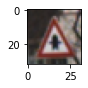

In [2]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = "/content/drive/MyDrive/Colab Notebooks/train.p"
validation_file="/content/drive/MyDrive/Colab Notebooks/valid.p"
testing_file = "/content/drive/MyDrive/Colab Notebooks/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

index = random.randint(0, n_test)
image = X_train[index].squeeze()

plt.figure(figsize = (1,1))
plt.imshow(image)
print(y_train[index])

In [3]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
# 데이터들의 형식은 (Set 갯수, 너비, 높이, channel)
# 28*28 사이즈의 이미지에 너비, 높이 2pixel씩 pad함.
X_train = np.pad(X_train, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
X_valid = np.pad(X_valid, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
X_test = np.pad(X_test, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0
#X_train = cv2.cvtColor(X_train, cv2.COLOR_RGB2GRAY)

정확도를 올리기 위해서 사용해 본 방법은 다음과 같습니다.
1. Hyperparameter 수정
1. 1*1 convolution layer 추가
1. fully connected layer 추가
1. dropout 추가
1. 이미지 정규화 범위 수정
1. 가중치 초기화 다른 방법 사용

이 중 결론적으로 사용한 방법은 1, 2, 3번 입니다.
EPOCHS를 10~200까지 증가시켜 보면서 가장 유효 검증 정확도가 높게 나온 EPOCHS = 50을 채택했습니다.
그리고 계산량을 줄이고 비선형성을 추가하는 1*1 convolution layer를 추가하였고, fully connected layer를 더 깊게 하여 비선형성을 추가했습니다.

In [4]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
# 학습 파트
# Hyperparameter
EPOCHS = 50
BATCH_SIZE = 128
keep_prob = 0.8

# LeNet 함수
def LeNet(x):
    mu = 0
    sigma = 0.1

    conv1_out = 6
    conv2_out = 16
    conv3_out = 48
    fc1_in, fc1_out = 6*6*conv3_out, 256
    fc2_out = 128
    fc3_out = 84
 
    # ConvNet 1층
    # 가중치(필터): 5*5, 입력 3겹(3채널), 출력 6겹
    conv1_W = tf.Variable(tf.truncated_normal(shape = (5, 5, 3, conv1_out), mean = mu, stddev = sigma), name = "w1")
    conv1_b = tf.Variable(tf.zeros(conv1_out))
    conv1 = tf.nn.conv2d(x, conv1_W, strides = [1, 1, 1, 1], padding = 'VALID') + conv1_b
 
    # convolution padding
    # same: new_width = in_width / stride_width
    # vaild: new_width = (in_width - filter_width+1) / strid_width
    conv1 = tf.nn.relu(conv1)
    # max pooling 1층 - depth 변화 없음
    conv1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')
    # pooling padding
    # new_width = (input_width - filter_width) / stride_width + 1
    
    # ConvNet 2층 - 1*1 convolution
    # 가중치(필터) 5*5, 입력 6겹, 출력 16겹
    conv2_W = tf.Variable(tf.truncated_normal(shape = (1, 1, conv1_out, conv2_out), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(conv2_out))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides = [1, 1, 1, 1], padding = 'VALID') + conv2_b
 
    conv2 = tf.nn.relu(conv2)
    # max pooling 2층 - depth 변화 없음
    # conv2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')

    # ConvNet 3층 
    # 가중치(필터) 5*5, 입력 16겹, 출력 48겹
    conv3_W = tf.Variable(tf.truncated_normal(shape = (5, 5, conv2_out, conv3_out), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(conv3_out))
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides = [1, 1, 1, 1], padding = 'VALID') + conv3_b
 
    conv3 = tf.nn.relu(conv3)
    # max pooling 2층 - depth 변화 없음
    conv3 = tf.nn.max_pool(conv3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')

    # conv3 출력값 shape(128, 6*6*48 = 1748)으로 평평하게(flatten하게) 만듦
    fc0 = flatten(conv3)

    # Full Connnected Layers
    fc1_W = tf.Variable(tf.truncated_normal(shape = (fc1_in, fc1_out), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(fc1_out))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
 
    fc1 = tf.nn.relu(fc1)
    # fc1 = tf.nn.dropout(fc1, keep_prob)

    fc2_W = tf.Variable(tf.truncated_normal(shape = (fc1_out, fc2_out), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(fc2_out))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
 
    fc2 = tf.nn.relu(fc2)
    # fc2 = tf.nn.dropout(fc2, keep_prob)

    fc3_W = tf.Variable(tf.truncated_normal(shape = (fc2_out, fc3_out), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(fc3_out))
    fc3 = tf.matmul(fc2, fc3_W) + fc3_b
 
    fc3 = tf.nn.relu(fc3)
    # fc3 = tf.nn.dropout(fc3, keep_prob)

    fc4_W = tf.Variable(tf.truncated_normal(shape = (fc3_out, n_classes), mean = mu, stddev = sigma))
    fc4_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
 
    return logits

In [5]:
x = tf.placeholder(tf.float32, (None, 36, 36, 3))
# 수정: one_hot 함수의 파라미터 자료형이 int형 종류만 받아서 int32로 수정
y = tf.placeholder(tf.int32, (None))

# LeNet 알고리즘의 결과물과 one_hot_y로 가중치를 수정하는 과정.
# Tensorflow 2에서는 아래 과정을 session 대신 함수로 만들어 사용.
one_hot_y = tf.one_hot(y, n_classes)
 
rate = 0.001
logits = LeNet(x)
# 수정: 파라미터 이름 각각 지정해 줌
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
 
# 정확도 평가 과정 session에서 유효 검증 데이터를 입력하여 정확도를 평가
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

 
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [6]:
# 세션 실행
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
 
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {}".format(validation_accuracy))
        print()

    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'traffic_classi')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {}".format(test_accuracy))
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.7925170065594368

EPOCH 2 ...
Validation Accuracy = 0.8698412701115857

EPOCH 3 ...
Validation Accuracy = 0.9074829929539946

EPOCH 4 ...
Validation Accuracy = 0.921768707753309

EPOCH 5 ...
Validation Accuracy = 0.9272108841104573

EPOCH 6 ...
Validation Accuracy = 0.9215419501404103

EPOCH 7 ...
Validation Accuracy = 0.9396825399528556

EPOCH 8 ...
Validation Accuracy = 0.9074829929539946

EPOCH 9 ...
Validation Accuracy = 0.9328798188914518

EPOCH 10 ...
Validation Accuracy = 0.9185941045787058

EPOCH 11 ...
Validation Accuracy = 0.9156462585304329

EPOCH 12 ...
Validation Accuracy = 0.943764172335601

EPOCH 13 ...
Validation Accuracy = 0.9517006800288246

EPOCH 14 ...
Validation Accuracy = 0.9371882083734958

EPOCH 15 ...
Validation Accuracy = 0.9310657599075041

EPOCH 16 ...
Validation Accuracy = 0.9331065759907504

EPOCH 17 ...
Validation Accuracy = 0.9310657593939039

EPOCH 18 ...
Validation Accuracy = 0.9435374152363022

EPOCH 19

EPOCHS = 200의 결과값

EPOCHS = 200  
BATCH_SIZE = 128  
keep_prob = 0.8  

EPOCH 114 ...  
Validation Accuracy = 0.9612244897959183

EPOCH 115 ...  
Validation Accuracy = 0.9616780045351474

EPOCH 116 ...  
Validation Accuracy = 0.9619047619047619

EPOCH 117 ...  
Validation Accuracy = 0.9390022676547909

EPOCH 118 ...  
Validation Accuracy = 0.9163265308825608

EPOCH 119 ...  
Validation Accuracy = 0.9453514739499341

117즈음부터 다시 정확도가 하락하기 시작.

EPOCH 197 ...  
Validation Accuracy = 0.9476190476731108

EPOCH 198 ...  
Validation Accuracy = 0.9478458050427253

EPOCH 199 ...  
Validation Accuracy = 0.9476190476731108

EPOCH 200 ...  
Validation Accuracy = 0.9473922903034963

여러번 실행해 본 결과 EPOCHS = 50일 때 가장 좋은 결과를 낼 수 있었습니다.

EPOCHS = 50  
BATCH_SIZE = 128  
keep_prob = 0.8  

1번째 실행

EPOCH 48 ...  
Validation Accuracy = 0.9566893424036281

EPOCH 49 ...  
Validation Accuracy = 0.9564625850340136

EPOCH 50 ...  
Validation Accuracy = 0.9562358276643991

2번째 실행

EPOCH 48 ...  
Validation Accuracy = 0.9578231290084164

EPOCH 49 ...  
Validation Accuracy = 0.9578231290084164

EPOCH 50 ...  
Validation Accuracy = 0.9578231290084164